In [ ]:
from qiskit import QuantumCircuit, transpile
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import ParameterVector

from collections import defaultdict
import networkx as nx
import os
from qiskit_aer import AerSimulator

from copy import copy

In [4]:
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1.2
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
cm_colors = plt.get_cmap('Set2')


# IBM experiments

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()

In [6]:
backend = {}
# backend["ibm_torino"] = service.backend('ibm_torino', use_fractional_gates=True)
# backend["ibm_fez"] = service.backend('ibm_fez', use_fractional_gates=True)
# backend["ibm_marrakesh"] = service.backend('ibm_marrakesh', use_fractional_gates=True)
# backend["ibm_brisbane"] = service.backend('ibm_brisbane')



In [9]:
def layers_HE(backend):
    layers = [[], [], []]
    couplings = [] 
    for ij in list(backend.coupling_map):
        if ij not in couplings and (ij[1],ij[0]) not in couplings:
            couplings.append(ij) 
    couplings = {n:ij for n, ij in enumerate(couplings)}
    n_edges = len(couplings.keys())
    G = nx.Graph()
    G.add_nodes_from(couplings.keys())
    for i in range(n_edges):
        for j in range(i+1, n_edges):
            if couplings[i][0] in couplings[j] or couplings[i][1] in couplings[j]:

                G.add_edges_from([[i,j]])

    colors = nx.greedy_color(G, strategy="connected_sequential_bfs")
    for node, color in colors.items():
        layers[color].append(list(sorted(couplings[node])))

    return layers

# layers = layers_HE(backend["ibm_fez"])

# IBM QPUs Native Layout (NL)

In [10]:
layout_pos = {
    "ibm_heron-r1":{0:(0,0), 1:(0,1), 2:(0,2), 3:(0,3), 4:(0,4), 5:(0,5), 6:(0,6), 7:(0,7), 8:(0,8), 9:(0,9), 10:(0,10), 11:(0,11), 12:(0,12), 13:(0,13), 14:(0,14),
                    15:(1,0), 16:(1,4), 17:(1,8), 18:(1,12),
                    19:(2,0), 20:(2,1), 21:(2,2), 22:(2,3), 23:(2,4), 24:(2,5), 25:(2,6), 26:(2,7), 27:(2,8), 28:(2,9), 29:(2,10), 30:(2,11), 31:(2,12), 32:(2,13), 33:(2,14),
                    34:(3,2), 35:(3,6), 36:(3,10), 37:(3,14),
                    38:(4,0), 39:(4,1), 40:(4,2), 41:(4,3), 42:(4,4), 43:(4,5), 44:(4,6), 45:(4,7), 46:(4,8), 47:(4,9), 48:(4,10), 49:(4,11), 50:(4,12), 51:(4,13), 52:(4,14),
                    53:(5,0), 54:(5,4), 55:(5,8), 56:(5,12),
                    57:(6,0), 58:(6,1), 59:(6,2), 60:(6,3), 61:(6,4), 62:(6,5), 63:(6,6), 64:(6,7), 65:(6,8), 66:(6,9), 67:(6,10), 68:(6,11), 69:(6,12), 70:(6,13), 71:(6,14),
                    72:(7,2), 73:(7,6), 74:(7,10), 75 :(7,14),
                    76:(8,0), 77:(8,1), 78:(8,2), 79:(8,3), 80:(8,4), 81:(8,5), 82:(8,6), 83:(8,7), 84:(8,8), 85:(8,9), 86:(8,10), 87:(8,11), 88:(8,12), 89:(8,13), 90:(8,14),
                    91:(9,0), 92:(9,4), 93:(9,8), 94:(9,12),
                    95:(10,0), 96:(10,1), 97:(10,2), 98:(10,3), 99:(10,4), 100:(10,5), 101:(10,6), 102:(10,7), 103:(10,8), 104:(10,9), 105:(10,10), 106:(10,11), 107:(10,12), 108:(10,13), 109:(10,14),
                    110:(11,2), 111:(11,6), 112:(11,10), 113:(11,14),
                    114:(12,0),115:(12,1), 116:(12,2), 117:(12,3), 118:(12,4), 119:(12,5), 120:(12,6), 121:(12,7), 122:(12,8), 123:(12,9), 124:(12,10), 125:(12,11), 126:(12,12), 127:(12,13), 128:(12,14),
                    129:(13,0), 130:(13,4), 131:(13,8), 132:(13,12),},
    "ibm_heron-r2":{ 0:(0,0), 1:(0,1), 2:(0,2), 3:(0,3), 4:(0,4), 5:(0,5), 6:(0,6), 7:(0,7), 8:(0,8), 9:(0,9), 10:(0,10), 11:(0,11), 12:(0,12), 13:(0,13), 14:(0,14), 15:(0,15),
                16:(1,3), 17:(1,7), 18:(1,11),19:(1,15),
                20:(2,0), 21:(2,1), 22:(2,2), 23:(2,3), 24:(2,4), 25:(2,5), 26:(2,6), 27:(2,7), 28:(2,8), 29:(2,9), 30:(2,10), 31:(2,11), 32:(2,12), 33:(2,13), 34:(2,14), 35:(2,15),
                36:(3,1), 37:(3,5), 38:(3,9), 39:(3,13),
                40:(4,0), 41:(4,1), 42:(4,2), 43:(4,3), 44:(4,4), 45:(4,5), 46:(4,6), 47:(4,7), 48:(4,8), 49:(4,9), 50:(4,10), 51:(4,11), 52:(4,12), 53:(4,13), 54:(4,14), 55:(4,15),
                56:(5,3), 57:(5,7), 58:(5,11), 59:(5,15),
                60:(6,0), 61:(6,1), 62:(6,2), 63:(6,3), 64:(6,4), 65:(6,5), 66:(6,6), 67:(6,7), 68:(6,8), 69:(6,9), 70:(6,10), 71:(6,11), 72:(6,12), 73:(6,13), 74:(6,14), 75:(6,15),
                76:(7,1), 77:(7,5), 78:(7,9), 79:(7,13),
                80:(8,0), 81:(8,1), 82:(8,2), 83:(8,3), 84:(8,4), 85:(8,5), 86:(8,6), 87:(8,7), 88:(8,8), 89:(8,9), 90:(8,10), 91:(8,11), 92:(8,12), 93:(8,13), 94:(8,14), 95:(8,15),
                96:(9,3), 97:(9,7), 98:(9,11), 99:(9,15),
                100:(10,0), 101:(10,1), 102:(10,2), 103:(10,3), 104:(10,4), 105:(10,5), 106:(10,6), 107:(10,7), 108:(10,8), 109:(10,9), 110:(10,10), 111:(10,11), 112:(10,12), 113:(10,13), 114:(10,14), 115:(10,15),
                116:(11,1), 117:(11,5), 118:(11,9), 119:(11,13),
                120:(12,0), 121:(12,1), 122:(12,2), 123:(12,3), 124:(12,4), 125:(12,5), 126:(12,6), 127:(12,7), 128:(12,8), 129:(12,9), 130:(12,10), 131:(12,11), 132:(12,12), 133:(12,13), 134:(12,14), 135:(12,15),
                136:(13,3), 137:(13,7), 138:(13,11), 139:(13,15),
                140:(14,0), 141:(14,1), 142:(14,2), 143:(14,3), 144:(14,4), 145:(14,5), 146:(14,6), 147:(14,7), 148:(14,8), 149:(14,9), 150:(14,10), 151:(14,11), 152:(14,12), 153:(14,13), 154:(14,14), 155:(14,15),},
                
    "ibm_eagle-r3":{ 0:(0,0), 1:(0,1), 2:(0,2), 3:(0,3), 4:(0,4), 5:(0,5), 6:(0,6), 7:(0,7), 8:(0,8), 9:(0,9), 10:(0,10), 11:(0,11), 12:(0,12), 13:(0,13),
                  14:(1,0), 15:(1,4), 16:(1,8), 17:(1,12),
                  18:(2,0), 19:(2,1), 20:(2,2), 21:(2,3), 22:(2,4), 23:(2,5), 24:(2,6), 25:(2,7), 26:(2,8), 27:(2,9), 28:(2,10), 29:(2,11), 30:(2,12), 31:(2,13), 32:(2,14),
                  33:(3,2), 34:(3,6), 35:(3,10), 36:(3,14),
                  37:(4,0), 38:(4,1), 39:(4,2), 40:(4,3), 41:(4,4), 42:(4,5), 43:(4,6), 44:(4,7), 45:(4,8), 46:(4,9), 47:(4,10), 48:(4,11), 49:(4,12), 50:(4,13), 51:(4,14),
                  52:(5,0), 53:(5,4), 54:(5,8), 55:(5,12),
                  56:(6,0), 57:(6,1), 58:(6,2), 59:(6,3), 60:(6,4), 61:(6,5), 62:(6,6), 63:(6,7), 64:(6,8), 65:(6,9), 66:(6,10), 67:(6,11), 68:(6,12), 69:(6,13), 70:(6,14),
                  71:(7,2), 72:(7,6), 73:(7,10), 74 :(7,14),
                  75:(8,0), 76:(8,1), 77:(8,2), 78:(8,3), 79:(8,4), 80:(8,5), 81:(8,6), 82:(8,7), 83:(8,8), 84:(8,9), 85:(8,10), 86:(8,11), 87:(8,12), 88:(8,13), 89:(8,14),
                  90:(9,0), 91:(9,4), 92:(9,8), 93:(9,12),
                  94:(10,0), 95:(10,1), 96:(10,2), 97:(10,3), 98:(10,4), 99:(10,5), 100:(10,6), 101:(10,7), 102:(10,8), 103:(10,9), 104:(10,10), 105:(10,11), 106:(10,12), 107:(10,13), 108:(10,14),
                  109:(11,2), 110:(11,6), 111:(11,10), 112:(11,14),
                  113:(12,1), 114:(12,2), 115:(12,3), 116:(12,4), 117:(12,5), 118:(12,6), 119:(12,7), 120:(12,8), 121:(12,9), 122:(12,10), 123:(12,11), 124:(12,12), 125:(12,13), 126:(12,14),}
}


# QAOA Circuit: Optimal depth Heavy-Hex Layout

In [11]:
def full_qaoa_ibm(G, layers, sorted_gates, fractional_gates=False):
    """
    Constructs a QAOA (Quantum Approximate Optimization Algorithm) circuit for MaxCut 
    on IBM Quantum hardware.

    Parameters:
    - G: networkx.Graph
        The input graph for the MaxCut problem.
    - layers: int
        The number of QAOA layers (p).
    - sorted_gates: list of lists
        A precomputed list of edges sorted into different gate execution groups.
    - fractional_gates: bool (default=False)
        If True, uses fractional RZZ gates; otherwise, uses CX-RZ-CX decomposition.

    Returns:
    - qc: QuantumCircuit
        The constructed quantum circuit for QAOA.
    """

    # Define parameter vectors for QAOA angles
    betas = ParameterVector("betas", layers)  # Mixing angles
    gammas = ParameterVector("gamma", layers)  # Cost function angles

    # Get the number of nodes in the graph
    nodes = G.number_of_nodes()

    # Extract edge weights (default to 1 if not weighted)
    if nx.is_weighted(G):
        weights = {(i, j): G[i][j]["weight"] for i, j in G.edges}
    else:
        weights = {(i, j): 1 for i, j in G.edges}

    # Initialize a quantum circuit with 'nodes' qubits
    qc = QuantumCircuit(nodes)

    # Apply Hadamard gates to all qubits to create a superposition state
    qc.h(range(nodes))

    # Apply QAOA layers
    for p in range(layers):
        # Apply cost function unitary for each edge in the graph
        for edge_group in sorted_gates:  # Iterate over the different gate execution groups
            for i, j in G.edges():
                qbits = [i, j]
                if (list(reversed(qbits)) in edge_group or qbits in edge_group):
                    if fractional_gates:
                        # Use the RZZ gate directly if fractional gates are allowed
                        qc.rzz(2 * gammas[p] * round(weights[i, j], 4), *qbits)
                    else:
                        # Standard QAOA implementation with CX and RZ gates
                        qc.cx(*qbits)
                        qc.rz(2 * gammas[p] * round(weights[i, j], 4), j)
                        qc.cx(*qbits)

        # Apply mixing unitary using RX rotations
        qc.rx(-2 * betas[p], range(nodes))

    # Measure all qubits at the end
    qc.measure_all()

    return qc

# Objective Function

In [12]:
def cost_maxcut(bitstring, G):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    pos_bitstring = {j:i for i, j in enumerate(sorted(G.nodes()))}
    # Iterate through all edges in the graph
    for i, j in G.edges():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[pos_bitstring[i]] + bitstring[pos_bitstring[j]] in ["10", "01"]:
            cost += G[i][j]["weight"]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, G)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, G)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost and cost - max_cost > 1e-10:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, G)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, G)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


# Prepare circuits

In [37]:
# Dictionary to store results
results = {}

# Define the backend (quantum processor)
backend_name = "ibm_brisbane"
# backend_name = "ibm_fez"
# backend_name = "ibm_torino"

# Define the list of QAOA layers (p-values)
ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 40, 50, 75, 100, 
      150, 200, 300, 400, 500, 1000]

# Identify the processor type based on the backend
if backend_name in ["ibm_fez", "ibm_marrakesh"]:
    processor_type = "Heron-r2"
elif backend_name == "ibm_torino":
    processor_type = "Heron-r1"
elif backend_name == "ibm_brisbane":  
    processor_type = "Eagle-r3"

# Load problem data from stored file
problems = np.load(f"./Data/NL-problems.npy", allow_pickle=True).item()

# Store the graph problem and solutions for the selected processor
results["G"] = problems[processor_type]["G"]  # Graph instance
results["sols"] = problems[processor_type]["sol"]  # Optimal solutions

# Store problem metadata
results["nq"] = results["G"].number_of_nodes()  # Number of qubits (nodes in the graph)
results["shots"] = 1000  # Number of measurement shots
results["ps"] = ps  # List of QAOA layers

# Retrieve backend specifications
max_nq = backend[backend_name].num_qubits  # Maximum number of qubits
layers = layers_HE(backend[backend_name])  # Hardware-efficient layers

# Dictionary to store transpiled circuits
transpile_circs = {}

# Iterate over each QAOA depth (p)
for p in ps:
    print(f"Layer: -------  {p} ----------- ")

    # Generate QAOA circuit for the given depth
    qc = full_qaoa_ibm(results["G"], p, layers, fractional_gates=True)

    # Transpile the circuit for the target backend
    circ = transpile(qc, backend=backend[backend_name], 
                     optimization_level=1, initial_layout=range(max_nq))

    # Store transpiled circuit
    transpile_circs[p] = circ

# List to store final parameterized circuits
circuits = []

# Define delta values for parameter tuning
# deltas = np.linspace(0.5, 1.5, 10)  # Uncomment for multiple delta values
# deltas = [1]  # Used for most experiments

deltas = [0.75]  # Used only for fractional gates
results["Deltas"] = deltas  # Store delta values in results

# Iterate over each delta and QAOA depth
for delta in deltas:
    for p in ps:
        print(f"Layer: -------  {p} ----------- ")

        # Compute beta and gamma parameters
        betas = np.round(np.arange(1, p+1)[::-1] * delta/p, 4)
        gammas = np.round(np.arange(1, p+1) * delta/p, 4)

        # Assign computed parameters to the transpiled circuit
        trans_circ = transpile_circs[p].assign_parameters(np.concatenate((betas, gammas)))

        # Store final circuit in the list
        circuits.append(trans_circ)


Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------  13 ----------- 
Layer: -------  15 ----------- 
Layer: -------  20 ----------- 
Layer: -------  25 ----------- 
Layer: -------  30 ----------- 
Layer: -------  40 ----------- 
Layer: -------  50 ----------- 
Layer: -------  75 ----------- 
Layer: -------  100 ----------- 
Layer: -------  150 ----------- 
Layer: -------  200 ----------- 
Layer: -------  300 ----------- 
Layer: -------  400 ----------- 
Layer: -------  500 ----------- 
Layer: -------  1000 ----------- 
Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------

# Run Circuits

In [40]:
# Initialize the quantum sampler with the selected backend
sampler = Sampler(mode=backend[backend_name])

# Submit the quantum job with the prepared circuits and defined number of shots
submit_job = sampler.run(circuits, shots=results["shots"])

# Store the job ID to track and retrieve results later
results["id"] = submit_job.job_id()  

# Optional suffix for filename customization
extra = ""

# Save the results dictionary as a NumPy file for later analysis
np.save(f"./Data/{backend_name}/{results['nq']}_HE{extra}.npy", results)


# Retrieve information

In [41]:
# Define the number of qubits and backend for the experiment
n_qubits = 133
backend_name = "ibm_torino"

# Specify an extra tag for identifying different versions of results
extra = ""

# Load previously saved results from a NumPy file
results = np.load(f"./Data/{backend_name}/{n_qubits}_HE{extra}.npy", allow_pickle=True).item()

# Retrieve job results from IBM Quantum Service using the stored job ID
jobs = service.job(job_id=results["id"]).result()

# Extract measurement results from the job
# The `.meas.get_counts()` method retrieves the bitstring results of each circuit execution
samples_dict = [jobs[i].data.meas.get_counts() for i in range(len(jobs))]

# Process and store the results:
# - Reverse the bitstring keys (k[::-1]) for compatibility
# - Organize data based on deltas and p-values (QAOA layers)
results["samples"] = {
    delta: {
        p: {k[::-1]: v for k, v in samples_dict[i + nd * len(results["ps"])].items()}
        for i, p in enumerate(results["ps"])
    }
    for nd, delta in enumerate(results["Deltas"])
}


In [46]:
postprocessing = {}
postprocessing_mitig = {}
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["samples"][delta]:
        print(f" -----------  {p}   ---------")
        postprocessing[delta][p] = objective_MaxCut(results["samples"][delta][p], results["G"], results["sols"][0])
        new_samples = mitigate(results["samples"][delta][p], results["G"], random=True)
        postprocessing_mitig[delta][p] = objective_MaxCut(new_samples, results["G"], results["sols"][0])
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig
rand_samples = random_samples(1000, n_qubits)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["sols"][0])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=True), results["G"], results["sols"][0])

np.save(f"./Data/{backend_name}/{n_qubits}_HE{extra}.npy", results)

 -----------  3   ---------
 -----------  4   ---------
 -----------  5   ---------
 -----------  6   ---------
 -----------  7   ---------
 -----------  8   ---------
 -----------  9   ---------
 -----------  10   ---------
 -----------  13   ---------
 -----------  15   ---------
 -----------  20   ---------
 -----------  25   ---------
 -----------  30   ---------
 -----------  40   ---------
 -----------  50   ---------
 -----------  75   ---------
 -----------  100   ---------
 -----------  150   ---------
 -----------  200   ---------
 -----------  300   ---------
 -----------  400   ---------
 -----------  500   ---------
 -----------  1000   ---------


# AWS - experiments

In [13]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import Devices, LocalSimulator
from braket.circuits import Circuit

# from qiskit_braket_provider import BraketProvider
# aws_provider = BraketProvider()
# rigetti_ankaa_3 = aws_provider.get_backend("Ankaa-3")


In [23]:
backends = {}
backends["iqm_garnet"] = AwsDevice(Devices.IQM.Garnet)
backends["rigetti_ankaa_3"] = AwsDevice(Devices.Rigetti.Ankaa3)
backends["local_simulator"] = LocalSimulator()

In [18]:
def get_layers(G_backend):
    layers = [[], [], [], []]
    couplings = [] 
    for ij in list(G_backend.edges):
        if ij not in couplings and (ij[1],ij[0]) not in couplings:
            couplings.append(ij) 
    couplings = {n:ij for n, ij in enumerate(couplings)}
    n_edges = len(couplings.keys())
    G = nx.Graph()
    G.add_nodes_from(couplings.keys())
    for i in range(n_edges):
        for j in range(i+1, n_edges):
            if couplings[i][0] in couplings[j] or couplings[i][1] in couplings[j]:

                G.add_edges_from([[i,j]])

    colors = nx.greedy_color(G, strategy="connected_sequential_bfs")
    for node, color in colors.items():
        layers[color].append(tuple(sorted(couplings[node])))
    return layers



In [20]:
def qaoa_maxcut_aws_sorted(gammas, betas, G, layers):
    p = len(gammas) 
    nodes = G.nodes()
    weights = [G[i][j]["weight"] for i,j in G.edges()]
    max_weight = max(weights)
    qc = Circuit()
    qc.h(nodes)
    for pi in range(p):
        for layer in layers:
            for i, j in G.edges():
                if (i,j) in layer or (j,i) in layer:
                    qc.cnot(i, j)
                    qc.rz(j, 2 * gammas[pi] * G[i][j]["weight"]/max_weight)
                    qc.cnot(i, j)
        qc.rx(nodes, -2 * betas[pi])
    return qc

In [21]:
problems = np.load("./Data/NL-problems.npy", allow_pickle=True).item()
backend_name = "rigetti_ankaa_3"  # Active backend
# backend_name = "local_simulator"
# backend_name = "iqm_garnet"
problem = problems[backend_name]
layers = get_layers(problem["G"])
# Select the backend for quantum computation
# Uncomment the desired backend or set the active one

extra = "_1"
results = {}  # Dictionary to store experiment results

# ---------------------- Loading Problem Information ----------------------
# Load the problem graph
results["G"] = problems[backend_name]["G"] 

# Select the graph to use: 
# If using a real quantum backend, use the transformed graph (GT), 
# otherwise use the original problem graph (G) for the simulator
GT = results["G"]

# Load optimal solutions for the given problem size
sols = problems[backend_name]["sol"]  

# ---------------------- QAOA Configuration ----------------------

# Define the number of QAOA layers
# ps = [0, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25]  
ps = [3, 4, 5, 6, 7, 8, 9, 10]  
# ps = [3]
# ps = [10_000]  # Set a single large QAOA depth for testing

# Define delta values for parameter scaling
# deltas = np.linspace(0.5, 1.5, 10)  # Generate 10 values between 0.5 and 1.5
deltas = [1]  # Set a single delta value for testing

# Store key experiment parameters in results
results["optimal"] = sols  
results["nq"] = GT.number_of_nodes()
results["edges"] = GT.number_of_edges()
results["ps"] = ps  
results["Deltas"] = deltas  

# ---------------------- Circuit Compilation ----------------------

circuits = []
# Iterate over different QAOA layers
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")  # Display current delta value
    for p in ps:
        print(f"Layer: -------  {p} ----------- ")  # Display current layer
        
        betas = list(np.arange(1, p+1)[::-1] * delta/p)  # Reverse sequence for betas
        gammas = list(np.arange(1, p+1) * delta/p)  # Forward sequence for gammas
        # Generate the QAOA circuit for MaxCut problem
        circ_maxcut = qaoa_maxcut_aws_sorted(gammas, betas, GT, layers)
        # Store the transpiled circuit  
        circuits.append(circ_maxcut) 
         


Delta: -------  1 ----------- 
Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 


In [24]:
shots = 1_000

results["shots"] = shots
ids = {}
for i in range(len(circuits)):
# run circuit
    task = backends[backend_name].run(circuits[i], shots=shots, disable_qubit_rewiring=True)
    ids[ps[i]] = task.id
    # get id and status of submitted quantum task

    status = task.state()
    # print('ID of quantum task:', iqm_task_id)
    print('Status of quantum task:', status)
results["ids"] = ids
np.save(f"./Data/{backend_name}/{results['nq']}_NL{extra}.npy", results)

Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED
Status of quantum task: QUEUED


In [32]:
# backend_name = "iqm_garnet"
backend_name = "rigetti_ankaa_3"
extra = "_1"
nq = 82
results = np.load(f"./Data/{backend_name}/{nq}_NL{extra}.npy", allow_pickle=True).item()
results["ps"] = results["ps"][:3]
dict_results = [AwsQuantumTask(arn=results["ids"][p]).result().measurement_counts for p in results["ps"]]
sort_bitstrings = results["G"].nodes()

sorted_qubits = list(results["G"].nodes()) #sorted(list(results["G"].nodes()))
qubits_dict = {j:i for i,j in enumerate(sorted_qubits)}
results["samples"] = {delta:{p:{"".join(k[qubits_dict[ii]] for ii in sorted(results["G"].nodes())):v for k, v in dict_results[i+nd*len(results["ps"])].items()} for i, p in enumerate(results["ps"])} for nd, delta in enumerate(results["Deltas"])}

In [33]:
nq = results["G"].number_of_nodes()
nq_total = results["G"].number_of_nodes()
sections = nq_total // nq
results["sections"]  = sections
postprocessing = {}
postprocessing_mitig = {}
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}
        for sec in range(sections):
            samples_sec = defaultdict(int)
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec*nq:(sec+1)*nq]] += v
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])
            new_samples = mitigate(samples_sec, results["G"], random=False)
            
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

rand_samples = random_samples(10_000, nq)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

np.save(f"./Data/{backend_name}/{nq}_NL{extra}.npy", results)

----------- p = 3 -------------
----------- p = 4 -------------
----------- p = 5 -------------


Text(0.5, 0, 'p')

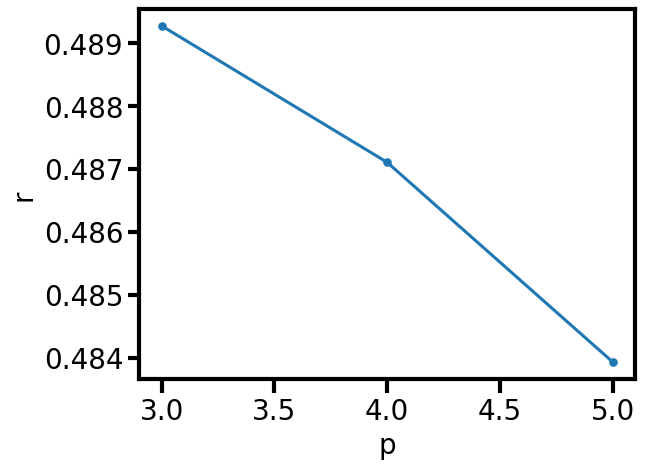

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
delta = results["Deltas"][0]
for i in range(results["sections"]):
    ax.plot(results["postprocessing"][delta].keys(), [results["postprocessing"][delta][p][i]["r"] for p in postprocessing[delta].keys()], marker="o")
ax.set_ylabel("r")
ax.set_xlabel("p")

In [110]:
results = np.load(f"./Data/iqm_garnet/20_NL.npy", allow_pickle=True).item()

task_load = AwsQuantumTask(arn=results["ids"][50])
metadata = task_load.metadata()
qpu_results = task_load.result()
circs_str =  qpu_results.additional_metadata.iqmMetadata.compiledProgram
print(f"The number of 2-qubit gates on IQM Garnet is: {circs_str.count('cz')}")

The number of 2-qubit gates on IQM Garnet is: 3000


In [132]:
backend_name = "rigetti_ankaa_3"
extra = ""
nq = 82
p = 40
results = np.load(f"./Data/{backend_name}/{nq}_NL{extra}.npy", allow_pickle=True).item()
G = results["G"]
N_edges = G.number_of_edges()
task_load = AwsQuantumTask(arn=results["ids"][p])
metadata = task_load.metadata()
qpu_results = task_load.result()
circs_str =  qpu_results.additional_metadata.rigettiMetadata.compiledProgram
print(f"The number of 2-qubit gates on {backend_name} is: {circs_str.count('ISWAP')} and should be {4*N_edges*p} with N_edges:{N_edges}")

The number of 2-qubit gates on rigetti_ankaa_3 is: 22080 and should be 22080 with N_edges:138


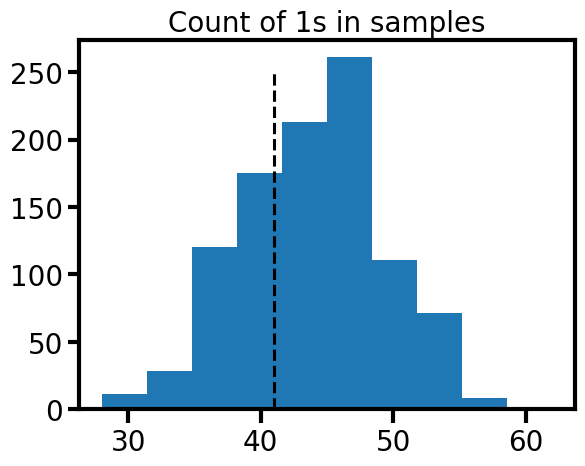

In [ ]:
fig, ax = plt.subplots()
ax.hist([k.count("1") for k in results["samples"][1][3]])
ax.set_title("Count of 1s in samples")
ax.vlines(nq/2, 0, 250, color="black", linestyles="--")

# Comparison of 3 and 4 regular graphs approximation ratio

In [147]:
from docplex.mp.model import Model

from qiskit_aer import AerSimulator

backend = AerSimulator()

def MaxCut(G):
    """
    Input:
        G: Networkx graph
    Output:
        mdl: Docplex model
    """
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    x = {i: mdl.binary_var(name=f"x_{i}") for i in sorted(G.nodes)}
    cost = 0
    for i, j in G.edges:
        if nx.is_weighted(G):
            cost += - G[i][j]["weight"] * (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
        else:
            cost += - (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
    mdl.minimize(cost)
    return mdl

def qaoa_maxcut(gammas, betas, G):
    total_qubits = G.number_of_nodes()
    p = len(gammas) 
    nodes = G.nodes()
    weights = [G[i][j]["weight"] for i,j in G.edges()]
    max_weight = max(np.abs(weights))
    qc = QuantumCircuit(total_qubits, len(nodes))
    qc.h(nodes)
    for pi in range(p):
        for i, j in G.edges():
            qc.rzz(2 * gammas[pi] * G[i][j]["weight"]/max_weight, i, j)
        qc.rx(-2*betas[pi], nodes)
    return qc


In [170]:
results = np.load("./Data/NL_regular_graph.npy", allow_pickle=True).item()

In [171]:
n_r = 5 
nq = 10
graph_name = f"regular_graph_{n_r}"
results[graph_name] = {}
random_cases = 10
for nq in [10, 20]:
    results[graph_name][nq] = {}
    for kk in range(random_cases):
        results[graph_name][nq][kk] = {}
        G = nx.random_regular_graph(n_r, nq)
        for i, j in G.edges():
            G[i][j]["weight"] = np.random.choice([0.05,0.1,0.25,1])
        mdl = MaxCut(G)
        mdl.solve()
        results[graph_name][nq][kk]["G"] = G
        results[graph_name][nq][kk]["optimal"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())

In [145]:
graph_name = "iqm_garnet"
nq = 20
results[graph_name] = {}
results[graph_name][nq] = {}
results[graph_name][nq][0] = {}
problems = np.load("./Data/NL-problems.npy", allow_pickle=True).item()
results[graph_name][nq][0]["G"] = problems["iqm_garnet"]["G"]
results[graph_name][nq][0]["optimal"] = problems["iqm_garnet"]["sol"][0]

In [174]:
graph_name = "iqm_garnet"
n_r = 5
graph_name = f"regular_graph_{n_r}"
delta_beta = 0.5
delta_gamma = 0.5
ps = [0,3,4,5,6,7,8,9,10,15,20,30,40,50]
shots = 10_000
for nq in results[graph_name].keys():
    print(f"--------  nq {nq} ----------")
    for kk in results[graph_name][nq].keys():
        print(f"--------  kk {kk} ----------")
        results[graph_name][nq][kk]["ps"] = ps
        for p in ps:
            G = results[graph_name][nq][kk]["G"]
            nq = G.number_of_nodes()
            gammas = np.arange(1, p+1) * delta_gamma/p
            betas = np.arange(1, p+1)[::-1] * delta_beta/p
            qc = qaoa_maxcut(gammas, betas, G)
            qc.measure(sorted(G.nodes()), reversed(range(nq)))
            samples = backend.run(qc, shots=shots).result().get_counts() 
            results[graph_name][nq][kk][p] = objective_MaxCut(samples, G, results[graph_name][nq][kk]["optimal"])
    


--------  nq 10 ----------
--------  kk 0 ----------
--------  kk 1 ----------
--------  kk 2 ----------
--------  kk 3 ----------
--------  kk 4 ----------
--------  kk 5 ----------
--------  kk 6 ----------
--------  kk 7 ----------
--------  kk 8 ----------
--------  kk 9 ----------
--------  nq 20 ----------
--------  kk 0 ----------
--------  kk 1 ----------
--------  kk 2 ----------
--------  kk 3 ----------
--------  kk 4 ----------
--------  kk 5 ----------
--------  kk 6 ----------
--------  kk 7 ----------
--------  kk 8 ----------
--------  kk 9 ----------


In [175]:
np.save("./Data/NL_regular_graph.npy", results)